In [1]:
import sys
import numpy as np


def preprocess(text):
    text = text.lower()
    text = text.replace('.',' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = []

    idx = 0;

    for word in words :
        if word in word_to_id : continue
        word_to_id[word] = idx
        id_to_word.append(word)
        idx += 1
    corpus = np.array([word_to_id[w] for w in words])
    return corpus, word_to_id, id_to_word 



In [2]:
text = "You say goodbye and I say hello."
corpus,word_to_id,id_to_word  = preprocess(text)


" ".join([id_to_word[i] for i in corpus])

'you say goodbye and i say hello .'

## 共现矩阵

In [3]:
def create_co_matrix(corpus,vocab_size,window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size,vocab_size),dtype=np.int32)
   # print(corpus[0:-1])

    for idx, word_id in enumerate(corpus[0 : -window_size]):
        for i in range(idx + 1,idx + window_size+1 ):
            join_id=corpus[i]
            co_matrix[word_id,join_id] += 1
            co_matrix[join_id,word_id] += 1

    return co_matrix



C = create_co_matrix(corpus,len(id_to_word))




In [4]:
## 两个相量的余弦相似度
def cos_similarity(x,y,eps = 1e-8):
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return nx @ ny



## 计算整个矩阵的余弦相似度
def cos_similarity_matrix(A,eps=1e-8):
  #  print(A.shape)

    na = A/(np.sqrt(np.sum(A ** 2,axis=1,keepdims=True)) + 1e-8 )
#    print(na.shape)
    
    result = na @ na.T
    print(result.shape)
    return result



#print(word_to_id)

C0 = C[word_to_id["i"]]
C1 = C[word_to_id["you"]]
print(cos_similarity(C0,C1))


cos_C = cos_similarity_matrix(C) 
print(cos_C[word_to_id["i"],word_to_id["you"]])
#print(cos_C[C0])

# print(cos_C[C0][C1])
##print(cos_C)

#print(f"v1,v2 {cos_similarity(C[word_to_id["i"]],C[word_to_id["you"]])}")


0.7071067691154799
(7, 7)
0.7071067691154799


In [113]:
## 单词相似度排序

you_idx = word_to_id["you"]
you_vet = cos_C[you_idx]
print(you_vet)

similar_idx = (-1 *  you_vet).argsort()

np.array(id_to_word)[similar_idx]


[0.99999998 0.         0.70710677 0.         0.70710677 0.70710677
 0.        ]


array(['you', 'goodbye', 'i', 'hello', 'say', 'and', '.'], dtype='<U7')

In [5]:
##print(C)
### 点互信息 (Pointwise Matual Information)


def ppmi(C,verbose=False,eps=1e-8):
    S = np.sum(C,axis=0).reshape(-1,1)
    N = np.sum(C)
    M =np.log2( C * N   / ((S * S.T)+ eps)) 
    M[M == -np.inf] = 0
    return M

W = ppmi(C)
print(W)


[[0.         1.80735492 0.         0.         0.         0.
  0.        ]
 [1.80735492 0.         0.80735492 0.         0.80735492 0.80735492
  0.        ]
 [0.         0.80735492 0.         1.80735492 0.         0.
  0.        ]
 [0.         0.         1.80735492 0.         1.80735492 0.
  0.        ]
 [0.         0.80735492 0.         1.80735492 0.         0.
  0.        ]
 [0.         0.80735492 0.         0.         0.         0.
  2.80735491]
 [0.         0.         0.         0.         0.         2.80735491
  0.        ]]


<ipython-input-5-0370780256a7>:8: RuntimeWarning: divide by zero encountered in log2
  M =np.log2( C * N   / ((S * S.T)+ eps))


In [6]:
## 降维  （dimensionality reduction）
U , S , V = np.linalg.svd(W)
# print(U)



print(C.shape)

print(W[0])
print(U[0,:2])



(7, 7)
[0.         1.80735492 0.         0.         0.         0.
 0.        ]
[-2.22044605e-16  3.40948750e-01]


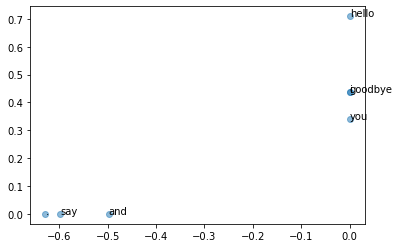

In [167]:
import matplotlib.pyplot as plt
for word,word_id in word_to_id.items():
    plt.annotate(word,(U[word_id,0],U[word_id,1]))

plt.scatter(U[:,0],U[:,1],alpha=0.5)
plt.show()



## ptb数据集测试

有别于书上的代码，此处我用改进的代码进行测试

In [7]:
import sys
sys.path.append("/Users/wzp/book/nature_language")
from dataset import ptb

corpus , word_to_id , id_to_word = ptb.load_data("train")


vocab_size = len(word_to_id)
window_size = 2
wordvec_size = 100


In [8]:

C = create_co_matrix(corpus,vocab_size,window_size=2)



In [173]:
print(C)

[[0 1 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [9]:
W = ppmi(C)

<ipython-input-5-0370780256a7>:8: RuntimeWarning: divide by zero encountered in log2
  M =np.log2( C * N   / ((S * S.T)+ eps))
<ipython-input-5-0370780256a7>:8: RuntimeWarning: invalid value encountered in log2
  M =np.log2( C * N   / ((S * S.T)+ eps))


In [10]:
print(W[2])

print(W.dtype)


[18.82623037 18.24126787  0.         ...  0.          0.
  0.        ]
float64


In [23]:
W = W.astype(np.float32)
W[np.isnan(W)] = 0
W[np.isinf(W)] = 0


In [28]:
# U, S, V = np.linalg.svd(W)
from sklearn.utils.extmath import randomized_svd
U , S , V = randomized_svd(W,n_components=vocab_size,n_iter=5,random_state=None)


In [29]:
S = cos_similarity_matrix(U)

(10000, 10000)


In [30]:
querys = ['you','year','car','toyota']

for query in querys:
    id = word_to_id[query]
    v = S[id]
    similar_idx = (-1 *  v).argsort()
    print(f'query {query}')
    for i in range(5):
        print(f'{id_to_word[similar_idx[i]]}: {v[similar_idx[i]]}')
    print("====")

query you
you: 1.000000238418579
closer: 1.2679083738476038e-07
development: 1.2171221897006035e-07
aimed: 1.139196683652699e-07
made: 1.1049814929720014e-07
====
query year
year: 0.9999998807907104
separate: 1.1792917575803585e-07
emphasis: 1.1755764717236161e-07
prepared: 1.1126758181490004e-07
operation: 1.093219452741323e-07
====
query car
car: 0.9999999403953552
graduates: 1.1893280316144228e-07
tank: 1.1597330740187317e-07
using: 1.1251904652453959e-07
expects: 1.0946678230538964e-07
====
query toyota
toyota: 0.9999999403953552
wanting: 1.385924406349659e-07
hailed: 1.2863893061876297e-07
blocked: 1.2456439435482025e-07
older: 1.209482434205711e-07
====
